## Two-dimensional diffusion equation
This python code was developed by Yamanaka research group of Tokyo University of Agriculture and Technology in August 2019.

## Problem
Let us consider an example problem: diffusion of a concentration-field $c(r, t)$ with a constant diffusion coefficient $D$. 
Here, $r$ denotes a two-dimensional coordinate point: $r = (x, y)$. $t$ represents time.  

## Diffusion equation
This notebook shows a two-dimensional diffusion simulation using the diffusion equation (see <a href="https://en.wikipedia.org/wiki/Diffusion_equation">Wikipedia</a>) given as:
$$
\frac{\partial c}{\partial t} = -Div \boldsymbol{J} = -\nabla \cdot \boldsymbol{J} = \nabla \cdot \left(D \nabla c\right)
$$
where $\boldsymbol{J} = -D \nabla c$ is a diffusion flux of the concentration which is derived by the Fick's first law. 

When the diffusion coefficient $D$ is constant, the diffusion equation can be written as: 
$$
\frac{\partial c}{\partial t} = D \nabla^{2} c = D \left( \frac{\partial^{2} c}{\partial x^{2}} + \frac{\partial^{2} c}{\partial y^{2}} \right)
$$

## Finite difference method
The diffusion equation is numerically solved by finite difference method (see  <a href="https://en.wikipedia.org/wiki/Finite_difference_method">Wikipedia</a>). In this code, let us consider two-dimensional regular finite difference grids with a constant spacing of the grids $\Delta x = \Delta y$.

The time integration for the left-hand side of the diffusion equation is calculated by the forward Euler method: 
$$
\frac{\partial c}{\partial t} \simeq \frac{c_{i,j}^{t+\Delta t} - c_{i,j}^{t}}{\Delta t}
$$
where $c_{i,j}^{t}$ denotes the concentation $c$ at a finite difference grid $(i, j)$ and time $t$. $\Delta t$ is a time increment. 

The second derivative of the concentration $c$ with respect to $x$ and $y$ for the right-hand side of the diffusion equation is calculated by the 2nd-order central finite difference method: 
$$
\frac{\partial^{2} c}{\partial x^{2}} \simeq \frac{c_{i+1,j}^{t} - 2c_{i,j}^{t} +c_{i-1,j}^{t}}{(\Delta x)^{2}}
$$
$$
\frac{\partial^{2} c}{\partial y^{2}} \simeq \frac{c_{i,j+1}^{t} - 2c_{i,j}^{t} +c_{i,j-1}^{t}}{(\Delta y)^{2}}
$$

Substituting the above equations into the diffusion equation, the discretized diffusion equation is given as: 
$$
c_{i,j}^{t+\Delta t} = c_{i,j}^{t} + D\left[ \frac{c_{i+1,j}^{t} - 2c_{i,j}^{t} +c_{i-1,j}^{t}}{(\Delta x)^{2}} + \frac{c_{i,j+1}^{t} - 2c_{i,j}^{t} +c_{i,j-1}^{t}}{(\Delta y)^{2}} \right] \Delta t
$$

## Programming 

### import libraries

In [1]:
%matplotlib nbagg
import numpy as np 
import matplotlib.pyplot as plt

!pip install pycuda # install pycuda
import pycuda.driver as drv
from pycuda.compiler import SourceModule

     |████████████████████████████████| 1.7 MB 5.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 75 kB 4.4 MB/s 
     |████████████████████████████████| 66 kB 4.4 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=626633 sha256=9f5b202b376bb8ef0bbdbaf2e6a3d98315fdf3a64a46e45de42ce50832540aa6
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2021.2.9-py2.py3-none-any.whl size=62370 sha256=4c4d729a0b5065c919807d319ac84db0674d9f383eb8718a3224713dc4790038
  Stored in directory: /root/.cache/pip/wheels/41/b9/6e/94bb014f6484b15ec77e7877f3a227609481ffd98db364504d
Successfully built pycuda pytools


### set parameters and physical values

In [2]:
nx, ny = 128, 128 # number of computational grids along x and y directions
dx = dy = 0.5 # spacing of finite difference grids [m]
D = 0.3 # diffusion coefficient [m2/s]
nsteps = 1000 # number of time steps
dt = dx*dx*dy*dy/(2*D*(dx*dx+dy*dy))*0.5 # time increment for 1 time step
c0 = 1.0 # initial concentration in a high concentration region

### declare arrays for concentration-field 

In [3]:
c = np.zeros((nx, ny)).astype(np.float32) # array for a concentration-fieldat time t 
c_new = np.zeros((nx, ny)).astype(np.float32) # array for a concentration-fieldat time t+dt

### define a function for solving the discretized diffusion equation
In this code, the zero-Neumann boundary condition which assumes zero-gradient of the concentration at the boundary of computational domain is used. 

In [4]:
# CUDA Cで記述する
def get_kernel_string(nx, ny, dx, dy, dt, D):
    return """
    #define nx %d
    #define ny %d
    #define dx %f
    #define dy %f
    #define dt %f
    #define D  %f
    __global__ void diffuse_kernel(float *u_new, float *u) {

        int i = blockIdx.x * block_size_x + threadIdx.x;
        int j = blockIdx.y * block_size_y + threadIdx.y;

        int ip = i + 1;
        int im = i - 1;
        int jp = j + 1;
        int jm = j - 1;
        if(ip > nx-1) { ip = nx - 1; }
        if(im < 0  ) { im = 0; }
        if(jp > ny-1) { jp = ny - 1;}
        if(jm < 0  ) { jm = 0; }

        u_new[j*nx+i] = u[j*nx+i] + D * ( (u[j*nx+ ip] - 2.0f*u[j*nx+i] + u[j*nx+ im])/dx/dx + ( u[( jp )*nx+i] - 2.0f*u[j*nx+i] + u[( jm )*nx+i] )/dy/dy )*dt;
    }
    """ % (nx, ny, dx, dy, dt, D)

kernel_string = get_kernel_string(nx, ny, dx, dy, dt, D)

### set the initial concentration-field

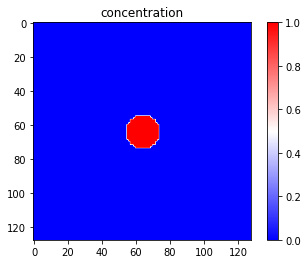

In [5]:
r = 5.0 # radius of the high-concentration region
x0 = nx/2 # central potition of the high-concentration region
y0 = ny/2

for i in range(nx):
    for j in range(ny):
        r2 = (i*dx-x0*dx)**2 + (j*dy-y0*dx)**2
        if r2 < r**2:
            c[i,j] = c0

plt.imshow(c, cmap='bwr')
plt.title('concentration')
plt.colorbar()
plt.show() 

### time integration of diffusion equation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: The CUDA compiler succeeded, but said the following:
nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).



1000 steps of diffuse took 14.855135917663574 ms.


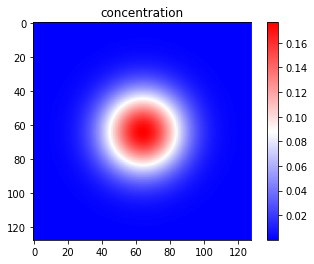

In [6]:
#initialize PyCuda and get compute capability needed for compilation
drv.init()
context = drv.Device(0).make_context()
devprops = { str(k): v for (k, v) in context.get_device().get_attributes().items() }
cc = str(devprops['COMPUTE_CAPABILITY_MAJOR']) + str(devprops['COMPUTE_CAPABILITY_MINOR'])

#allocate GPU memory
u_old = drv.mem_alloc(c.nbytes)
u_new = drv.mem_alloc(c_new.nbytes)

#setup thread block dimensions and compile the kernel
threads = (16,16,1)
grid = (int(nx/16), int(ny/16), 1)

block_size_string = "#define block_size_x 16\n#define block_size_y 16\n"
diffuse_kernel = SourceModule(block_size_string+kernel_string, arch='sm_'+cc).get_function("diffuse_kernel")

#create events for measuring performance
start = drv.Event()
end = drv.Event()

#move the data to the GPU
drv.memcpy_htod(u_old, c)
drv.memcpy_htod(u_new, c)

#call the GPU kernel a 1000 times and measure performance
context.synchronize()
start.record()
for i in range(500):
    diffuse_kernel(u_new, u_old, block=threads, grid=grid)
    diffuse_kernel(u_old, u_new, block=threads, grid=grid)
end.record()
context.synchronize()
print("1000 steps of diffuse took", end.time_since(start), "ms.")

#copy the result from the GPU to Python for plotting
gpu_result = np.zeros_like(c)
drv.memcpy_dtoh(gpu_result, u_new)

plt.imshow(gpu_result, cmap='bwr')
plt.title('concentration')
plt.colorbar()
plt.show() 